In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=3b0714521b17325f3b603a404c04df967f9ce9323b9102d7029866dd7e2507ee
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [50]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from pyspark.sql.functions import *
from pyspark.sql.types import *
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd
import tensorflow as tf
import xml.etree.ElementTree as ET
import numpy as np

In [ ]:
# Création de la session Spark
spark = SparkSession.builder \
    .appName("ExcelReader") \
    .config("spark.jars.packages", "com.crealytics:spark-excel_2.12:0.13.5") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Chemin du fichier Excel
file_path = "sample_data/olympic_medals.xlsx"

# Lecture du fichier Excel
olympic_medals_df  = spark.read.format("com.crealytics.spark.excel") \
    .option("treatEmptyValuesAsNulls", "true") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file_path)

# Parse XML data into a list of dictionaries
tree = ET.parse('sample_data/olympic_hosts.xml')
root = tree.getroot()

import xml.etree.ElementTree as ET

data_rows_full = []
for row in root.findall('row'):
    data_rows_full.append({
        'index': row.find('index').text,
        'game_slug': row.find('game_slug').text,
        'game_end_date': row.find('game_end_date').text,
        'game_start_date': row.find('game_start_date').text,
        'game_location': row.find('game_location').text,
        'game_name': row.find('game_name').text,
        'game_season': row.find('game_season').text,
        'game_year': row.find('game_year').text
    })

hosts_df = spark.createDataFrame(data_rows_full)
athletes_data = spark.read.csv('sample_data/olympic_athletes.csv', header=True, inferSchema=True)

In [ ]:
olympic_medals_df.show()

+----------------+------------+--------------------+------------+----------+----------------+-----------------+--------------------+--------------------+--------------------+------------+---------------------+
|discipline_title|   slug_game|         event_title|event_gender|medal_type|participant_type|participant_title|         athlete_url|   athlete_full_name|        country_name|country_code|country_3_letter_code|
+----------------+------------+--------------------+------------+----------+----------------+-----------------+--------------------+--------------------+--------------------+------------+---------------------+
|         Curling|beijing-2022|       Mixed Doubles|       Mixed|      GOLD|        GameTeam|            Italy|https://olympics....|Stefania CONSTANTINI|               Italy|          IT|                  ITA|
|         Curling|beijing-2022|       Mixed Doubles|       Mixed|      GOLD|        GameTeam|            Italy|https://olympics....|        Amos MOSANER|       

# Evènement marquants au **jo**

In [ ]:
# Question 1 - La France a organisé 6 JO : 3 d’hiver et 3 d’été (en comptant celui de 2024) ?La France a organisé 6 JO : 3 d’hiver et 3 d’été (en comptant celui de 2024) ?
winter_games = hosts_df.filter(col('game_season') == 'Winter')
summer_games = hosts_df.filter(col('game_season') == 'Summer')

winter_games_in_france = winter_games.filter(col('game_location') == 'France')
summer_games_in_france = summer_games.filter(col('game_location') == 'France')

num_winter_games_in_france = winter_games_in_france.select(countDistinct('game_slug')).collect()[0][0]
num_summer_games_in_france = summer_games_in_france.select(countDistinct('game_slug')).collect()[0][0]
print(num_winter_games_in_france, num_summer_games_in_france)

3 2


In [ ]:
# Question 2 - La France est le 2è pays qui a organisé le plus de JO après les USA (8 JO) ?
country_host_counts = hosts_df.groupBy('game_location').count().orderBy('count', ascending=False)
top_countries = country_host_counts.limit(10)
top_countries.show()

+-----------------+-----+
|    game_location|count|
+-----------------+-----+
|    United States|    8|
|           France|    5|
|            Japan|    4|
|    Great Britain|    3|
|            Italy|    3|
|           Canada|    3|
|Republic of Korea|    2|
|           Greece|    2|
|            China|    2|
|           Norway|    2|
+-----------------+-----+



In [ ]:
# Question 3 - Les JO d’hiver sont nés à Chamonix en 1924 ?

hosts_df = hosts_df.withColumn('game_start_date', col('game_start_date').cast('date'))
winter_games = hosts_df.filter(col('game_season') == 'Winter')
first_winter_olympics = winter_games.orderBy('game_start_date').first()

print(first_winter_olympics['game_name'], first_winter_olympics['game_year'], first_winter_olympics['game_location'], first_winter_olympics['game_start_date'])

Chamonix 1924 1924 France 1924-01-25


In [ ]:
# Question 4 - JO de Paris, en 1900 : les femmes peuvent participer aux JO ?

# Filter data for Paris 1900
paris_1900_data = olympic_medals_df.filter(olympic_medals_df.slug_game == "paris-1900")

# Check for female athletes participation
female_athletes_paris_1900 = paris_1900_data.filter(olympic_medals_df.event_gender == "Women").select("athlete_full_name").distinct()

# Count the number of female athletes
num_female_athletes_paris_1900 = female_athletes_paris_1900.count()

# Check if there were any female athletes
female_participation = num_female_athletes_paris_1900 > 0

# Display results
if female_participation:
    response = f"Oui, aux JO de Paris en 1900, {num_female_athletes_paris_1900} femmes ont participé d'après le dataset."
else:
    response = "Non, aux JO de Paris en 1900, les femmes n'ont pas participé."

print(response)


Oui, aux JO de Paris en 1900, 7 femmes ont participé d'après le dataset.


In [ ]:
# Question 5 - Seuls 4 athlètes ont remporté des médailles à la fois aux JO d’hiver et d’été. Une seule d’entre eux, Christa Ludinger-Rothenburger, a remporté des médailles au cours de la même année ?
christa_full_data = athletes_data.filter(col('athlete_full_name').contains('Christa LUDING-'))
christa_bio = christa_full_data.select('bio').collect()[0][0]

print(christa_bio)


Christa Luding-Rothenburger is the only person in any sport to have won medals in both the Olympic Winter and Summer Games in the same year.Gold in winterLuding-Rothenburger first competed in speed skating at the 1980 Games in Lake Placid, finishing 12th in the 500m and 18th in the 1,000m events. She entered the 1984 Winter Games in Sarajevo as the world record holder at 500m, and proceeded to win the gold medal in that event. She also placed fifth at 1,000m.Unbeatable at 1000mFour years later, at the Olympic Winter Games in Calgary, Luding-Rothenberger earned the silver medal in the 500m by finishing a mere two hundredths of a second behind Bonnie Blair. Four days later, Luding-Rothenberger won the gold medal at 1,000m and broke the world record.Silver in summerHer coach, Ernst Luding (whom she married in 1988) had persuaded her to take up cycling during the off season from skating. She quickly became a strong contender in this event, winning gold in the match sprint competition at th

In [ ]:
# Question 7 - Tarzan lui-même a participé aux JO. En effet, Johnny Weissmuller, ancien athlète devenu acteur et ayant interprété 12 films de Tarzan, a remporté 5 médailles d’or en natation dans les années 1920 ?

# Filter data for Johnny Weissmuller
johnny_data = olympic_medals_df.filter(olympic_medals_df.athlete_full_name.contains("Johnny WEISSMULLER"))

# Filter gold medals
johnny_gold_medals = johnny_data.filter(olympic_medals_df.medal_type == "GOLD")

# Group by discipline and game to count medals
johnny_gold_medals_summary = johnny_gold_medals.groupBy("discipline_title", "slug_game").count()

# Collect the results
johnny_gold_medals_summary_collect = johnny_gold_medals_summary.collect()

# Display the results
for row in johnny_gold_medals_summary_collect:
    print(f"Discipline: {row['discipline_title']}, Game: {row['slug_game']}, Gold Medals: {row['count']}")

# Count the total number of gold medals
total_gold_medals = sum(row['count'] for row in johnny_gold_medals_summary_collect)

# Formulate the response
if total_gold_medals == 5:
    response = "Oui, Johnny Weissmuller a remporté 5 médailles d'or en natation dans les années 1920."
else:
    response = f"Non, Johnny Weissmuller a remporté {total_gold_medals} médailles d'or en natation dans les années 1920."

response

Discipline: Swimming, Game: paris-1924, Gold Medals: 2
Discipline: Swimming, Game: amsterdam-1928, Gold Medals: 1


"Non, Johnny Weissmuller a remporté 3 médailles d'or en natation dans les années 1920."

In [ ]:
# Question 8 - Les JO de Londres de 2012 ont été les 1ers JO durant lesquels tous les pays participants ont envoyé des athlètes de sexe féminin ?

# Filter data for London 2012
london_2012_data = olympic_medals_df.filter(olympic_medals_df.slug_game == "london-2012")

# Check for female athletes participation by country
countries_with_female_athletes = london_2012_data.filter(olympic_medals_df.event_gender == "Women").select("country_name").distinct()
all_countries = london_2012_data.select("country_name").distinct()

# Count the number of countries
num_countries_with_female_athletes = countries_with_female_athletes.count()
num_all_countries = all_countries.count()

# Check if all countries sent female athletes
all_countries_sent_female_athletes = num_countries_with_female_athletes == num_all_countries

# Display the results
num_countries_with_female_athletes, num_all_countries, all_countries_sent_female_athletes

# Formulate the response
if all_countries_sent_female_athletes:
    response = "Oui, les JO de Londres de 2012 ont été les premiers JO durant lesquels tous les pays participants ont envoyé des athlètes de sexe féminin."
else:
    response = f"Non, aux JO de Londres de 2012, {num_countries_with_female_athletes} sur {num_all_countries} pays ont envoyé des athlètes de sexe féminin."

response


'Non, aux JO de Londres de 2012, 61 sur 85 pays ont envoyé des athlètes de sexe féminin.'

In [ ]:
# Question 10 - Les Jeux de 2016, à Rio, marqueront la 1è manifestation des JO en Amérique du Sud ? Les Jeux de 2016, à Rio, marqueront la 1è manifestation des JO en Amérique du Sud ?
rio_2016_data = hosts_df.filter(col('game_slug').contains('rio-2016'))
previous_south_american_games = hosts_df.filter((col('game_year') < 2016) & (col('game_location').rlike('Brazil|Argentina|South America')))

print(rio_2016_data.collect(), previous_south_american_games.collect())

[Row(game_end_date='2016-08-21T21:00:00Z', game_location='Brazil', game_name='Rio 2016', game_season='Summer', game_slug='rio-2016', game_start_date='2016-08-05T12:00:00Z', game_year='2016', index='3')] []


# Questions ouvertes

In [ ]:
# Supprimer les doublons
olympic_medals_df = olympic_medals_df.dropDuplicates()

# Filtrer les données pour la France
france_medals = olympic_medals_df.filter(col("country_name") == "France")

# Compter le nombre total de médailles
total_medals = france_medals.count()

# Compter le nombre de médailles d'or, d'argent et de bronze
medals_count = france_medals.groupBy("medal_type").count()

# Extraire les comptes des médailles d'or, d'argent et de bronze
gold_medals = medals_count.filter(col("medal_type") == "GOLD").select("count").collect()[0][0]
silver_medals = medals_count.filter(col("medal_type") == "SILVER").select("count").collect()[0][0]
bronze_medals = medals_count.filter(col("medal_type") == "BRONZE").select("count").collect()[0][0]

print(f"Total des médailles remportées par la France : {total_medals}")
print(f"Médailles d'Or : {gold_medals}")
print(f"Médailles d'Argent : {silver_medals}")
print(f"Médailles de Bronze : {bronze_medals}")


Total des médailles remportées par la France : 952
Médailles d'Or : 282
Médailles d'Argent : 305
Médailles de Bronze : 365


In [ ]:
# Supprimer les doublons
olympic_medals_df = olympic_medals_df.dropDuplicates()

# Filtrer les données pour la France
france_medals = olympic_medals_df.filter(col("country_name") == "France")

# Group by the Olympic Games and count the number of medals for each game
medals_by_game = france_medals.groupBy("slug_game").agg(count("*").alias("medal_count"))

# Find the game with the maximum and minimum number of medals
most_successful = medals_by_game.orderBy(col("medal_count").desc()).first()
least_successful = medals_by_game.orderBy(col("medal_count").asc()).first()

# Afficher les résultats
print(f"L'édition des JO la plus réussie pour la France : {most_successful['slug_game']} avec {most_successful['medal_count']} médailles")
print(f"L'édition des JO la moins réussie pour la France : {least_successful['slug_game']} avec {least_successful['medal_count']} médailles")

L'édition des JO la plus réussie pour la France : paris-1900 avec 103 médailles
L'édition des JO la moins réussie pour la France : garmisch-partenkirchen-1936 avec 1 médailles


In [ ]:
# Supprimer les doublons
olympic_medals_df = olympic_medals_df.dropDuplicates()

# Filtrer les données pour la France
france_medals = olympic_medals_df.filter(col("country_name") == "France")

# Grouper les données par discipline et compter les médailles pour chaque discipline pour la France
france_disciplines = france_medals.groupBy("discipline_title").count().withColumnRenamed("count", "france_medal_count")

# Grouper les données par discipline et compter les médailles totales pour chaque discipline
total_disciplines = olympic_medals_df.groupBy("discipline_title").count().withColumnRenamed("count", "total_medal_count")

# Fusionner les deux DataFrames sur la colonne 'discipline_title'
merged_disciplines = france_disciplines.join(total_disciplines, on="discipline_title")

# Calculer la proportion des médailles de la France dans chaque discipline
merged_disciplines = merged_disciplines.withColumn("proportion", col("france_medal_count") / col("total_medal_count"))

# Trouver la ou les disciplines où la France a la plus grande proportion de médailles
top_disciplines = merged_disciplines.orderBy(col("proportion").desc())

# Afficher les résultats
top_disciplines.show(truncate=False)

+---------------------+------------------+-----------------+-------------------+
|discipline_title     |france_medal_count|total_medal_count|proportion         |
+---------------------+------------------+-----------------+-------------------+
|Croquet              |8                 |8                |1.0                |
|Water Motorsports    |1                 |3                |0.3333333333333333 |
|Equestrian  Vaulting |2                 |6                |0.3333333333333333 |
|Military Patrol      |1                 |3                |0.3333333333333333 |
|Fencing              |123               |668              |0.18413173652694612|
|Canoe Slalom         |22                |132              |0.16666666666666666|
|Rugby Sevens         |1                 |6                |0.16666666666666666|
|Cycling Mountain Bike|6                 |42               |0.14285714285714285|
|Cycling Track        |74                |578              |0.12802768166089964|
|Rugby                |2    

In [ ]:
# Supprimer les doublons
olympic_medals_df = olympic_medals_df.dropDuplicates()

# Grouper les données par discipline et compter les médailles totales pour chaque discipline
total_medals_by_discipline = olympic_medals_df.groupBy("discipline_title").count().withColumnRenamed("count", "total_medal_count")

# Trier les disciplines par le nombre total de médailles en ordre décroissant
dominant_sports = total_medals_by_discipline.orderBy(col("total_medal_count").desc())

# Afficher les résultats
dominant_sports.show(10, truncate=False)


+-------------------+-----------------+
|discipline_title   |total_medal_count|
+-------------------+-----------------+
|Athletics          |3080             |
|Swimming           |1763             |
|Wrestling          |1356             |
|Rowing             |1072             |
|Boxing             |996              |
|Gymnastics Artistic|979              |
|Shooting           |871              |
|Canoe Sprint       |799              |
|Sailing            |771              |
|Weightlifting      |679              |
+-------------------+-----------------+
only showing top 10 rows



In [ ]:
# Supprimer les colonnes inutiles
data_cleaned = olympic_medals_df.drop("Unnamed: 0", "athlete_url")

# Visualisation des données

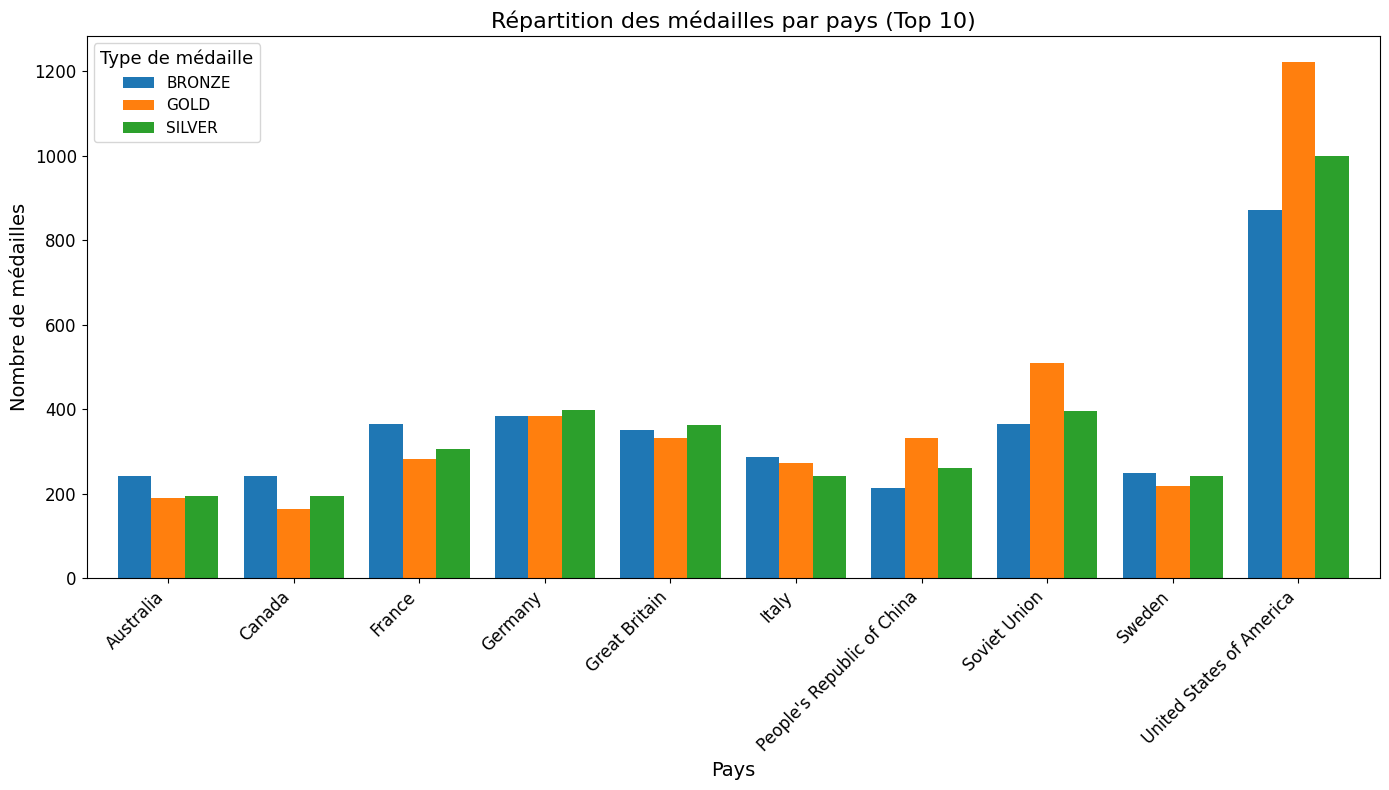

In [ ]:
# Filtrer pour obtenir les 10 premiers pays ayant le plus de médailles
top_countries_df = data_cleaned.groupBy("country_name").count().orderBy("count", ascending=False).limit(10)

# Joindre avec les données originales pour ne garder que les 10 premiers pays
filtered_df = data_cleaned.join(top_countries_df, on="country_name", how="inner")

# Grouper par pays et type de médaille et compter les occurrences
medals_by_country = filtered_df.groupBy("country_name", "medal_type").count()

# Convertir le DataFrame Spark en Pandas DataFrame
medals_by_country_pd = medals_by_country.toPandas()

# Transformer les données pour le graphique
medals_by_country_unstacked = medals_by_country_pd.pivot(index='country_name', columns='medal_type', values='count').fillna(0)

# Plotting the data with side-by-side bars
fig, ax = plt.subplots(figsize=(14, 8))

medals_by_country_unstacked.plot(kind='bar', ax=ax, width=0.8)

plt.title('Répartition des médailles par pays (Top 10)', fontsize=16)
plt.xlabel('Pays', fontsize=14)
plt.ylabel('Nombre de médailles', fontsize=14)
plt.legend(title='Type de médaille', title_fontsize='13', fontsize='11')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()

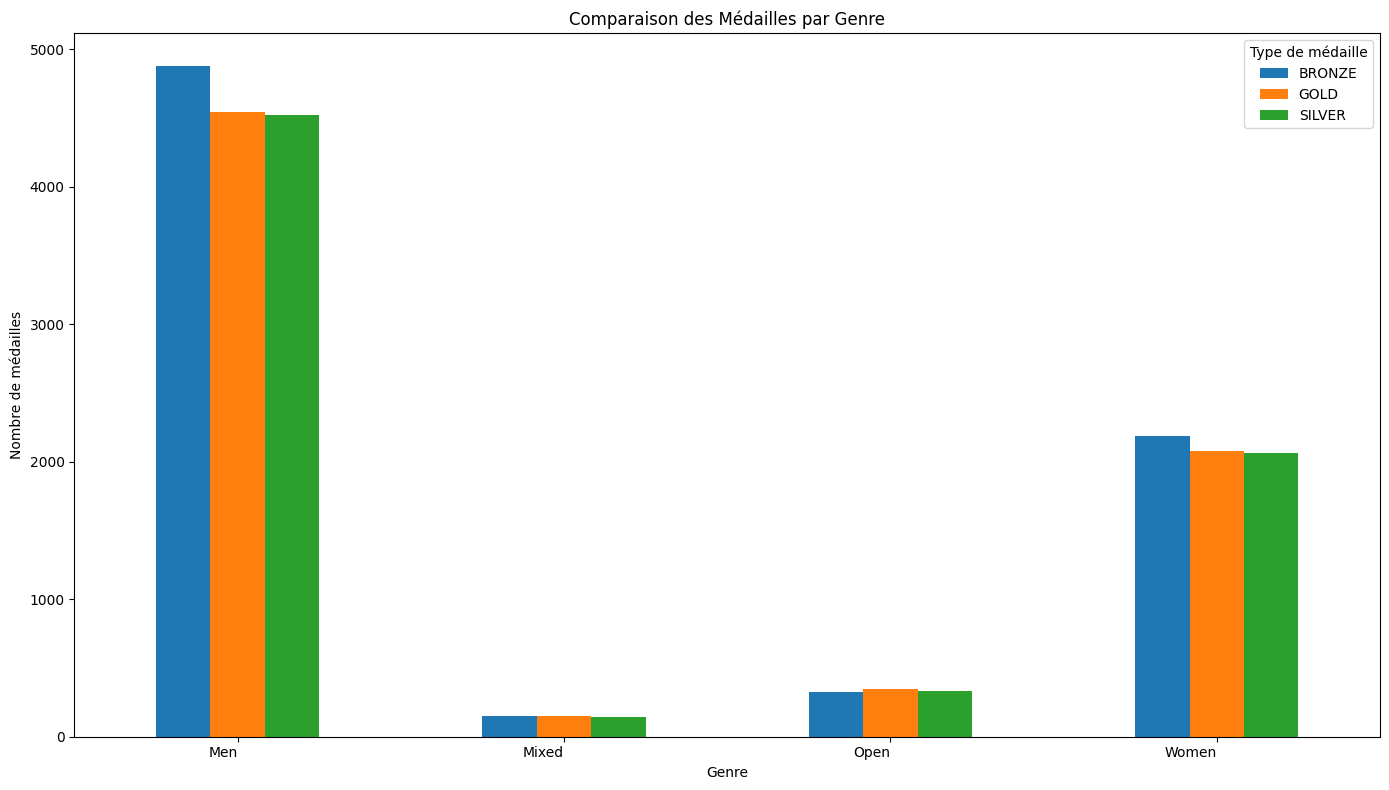

In [ ]:
# Grouper les données par genre et type de médaille
medals_by_gender_spark =  data_cleaned.groupBy("event_gender", "medal_type").count()

# Convertir le DataFrame Spark en Pandas DataFrame
medals_by_gender_pd = medals_by_gender_spark.toPandas()

# Transformer les données pour le graphique
medals_by_gender_unstacked = medals_by_gender_pd.pivot(index='event_gender', columns='medal_type', values='count').fillna(0)

# Plotting the data with stacked bars
fig, ax = plt.subplots(figsize=(14, 8))

medals_by_gender_unstacked.plot(kind='bar', ax=ax)

plt.title('Comparaison des Médailles par Genre')
plt.xlabel('Genre')
plt.ylabel('Nombre de médailles')
plt.legend(title='Type de médaille')
plt.xticks(rotation=0, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

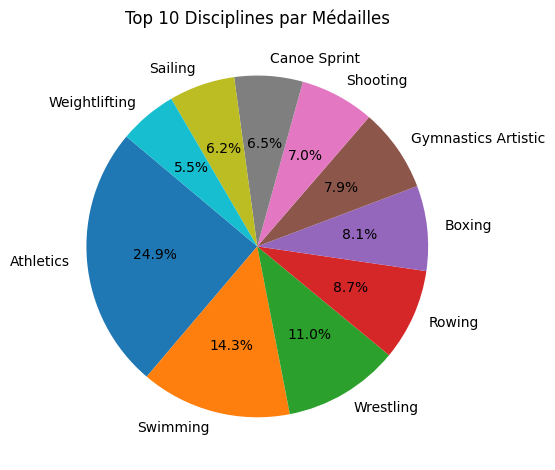

In [ ]:
# Grouper les données par discipline et compter les médailles
medals_by_discipline_spark = data_cleaned.groupBy("discipline_title").count()

# Trier par ordre décroissant et sélectionner les 10 premières disciplines
top_10_disciplines_spark = medals_by_discipline_spark.orderBy(col("count").desc()).limit(10)

# Convertir le DataFrame Spark en Pandas DataFrame
top_10_disciplines_pd = top_10_disciplines_spark.toPandas()

# Plotting the data with a pie chart
plt.figure(figsize=(14, 8))
top_10_disciplines_pd.set_index('discipline_title').plot(kind='pie', y='count', autopct='%1.1f%%', startangle=140, legend=False)

plt.title('Top 10 Disciplines par Médailles')
plt.ylabel('')  # Hide the y-label

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Filtrer les données pour ne garder que les Jeux Olympiques d'été
summer_games = ['athens-1896', 'paris-1900', 'st-louis-1904', 'london-1908', 'stockholm-1912',
                'antwerp-1920', 'paris-1924', 'amsterdam-1928', 'los-angeles-1932', 'berlin-1936',
                'london-1948', 'helsinki-1952', 'melbourne-1956', 'rome-1960', 'tokyo-1964',
                'mexico-city-1968', 'munich-1972', 'montreal-1976', 'moscow-1980', 'los-angeles-1984',
                'seoul-1988', 'barcelona-1992', 'atlanta-1996', 'sydney-2000', 'athens-2004',
                'beijing-2008', 'london-2012', 'rio-2016', 'tokyo-2020']
data_summer = data_cleaned.filter(col("slug_game").isin(summer_games))

In [ ]:
# Filtrer les données pour ne garder que celles de la France
data_france = data_summer.filter(col("country_name") == "France")

In [ ]:
# Supprimer les doublons en conservant une seule ligne pour chaque combinaison d'événement et de médaille
data_france = data_france.dropDuplicates(["discipline_title", "slug_game", "event_title", "medal_type", "country_name"])

In [ ]:
data_france.count()

743

In [ ]:
# Définir les colonnes catégorielles
categorical_columns = ['discipline_title', 'event_title', 'event_gender', 'medal_type', 'participant_type']


In [ ]:
# Encodage des variables catégorielles
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(data_france) for column in categorical_columns]
pipeline = Pipeline(stages=indexers)
data_france = pipeline.fit(data_france).transform(data_france)

In [ ]:
# Extraire l'année du slug_game
data_france = data_france.withColumn("year", expr("split(slug_game, '-')[1]").cast("int"))


In [ ]:
# Grouper les données par année et compter le nombre de médailles d'or, d'argent et de bronze
medal_counts = data_france.groupBy("year").pivot("medal_type").count().fillna(0)


In [ ]:
# Assemblage des caractéristiques
assembler = VectorAssembler(inputCols=["year"], outputCol="features")
medal_counts = assembler.transform(medal_counts)


In [ ]:
# Séparation des données en ensembles d'entraînement et de test
train_data, test_data = medal_counts.randomSplit([0.8, 0.2], seed=42)


In [ ]:
# Convertir les données de Spark DataFrame en Pandas DataFrame pour utilisation avec XGBoost
def convert_to_pandas(df):
    return df.toPandas()

In [ ]:
train_data_pd = convert_to_pandas(train_data)
test_data_pd = convert_to_pandas(test_data)

In [ ]:
X_train = train_data_pd[['year']]
y_train_gold = train_data_pd['GOLD']
y_train_silver = train_data_pd['SILVER']
y_train_bronze = train_data_pd['BRONZE']

X_test = test_data_pd[['year']]
y_test_gold = test_data_pd['GOLD']
y_test_silver = test_data_pd['SILVER']
y_test_bronze = test_data_pd['BRONZE']

#Utilisation d'un Modèle GradientBoostingRegressor (ML)

In [ ]:
# Entraîner un modèle GradientBoostingRegressor pour chaque type de médaille
def train_gb_model(X_train, y_train, X_test, y_test):
    model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    return model, rmse, y_pred

gb_model_gold, rmse_gold_gb, y_pred_gold_gb = train_gb_model(X_train, y_train_gold, X_test, y_test_gold)
gb_model_silver, rmse_silver_gb, y_pred_silver_gb = train_gb_model(X_train, y_train_silver, X_test, y_test_silver)
gb_model_bronze, rmse_bronze_gb, y_pred_bronze_gb = train_gb_model(X_train, y_train_bronze, X_test, y_test_bronze)


In [ ]:
# Afficher les RMSE
print("RMSE Gold (GradientBoosting):", rmse_gold_gb)
print("RMSE Silver (GradientBoosting):", rmse_silver_gb)
print("RMSE Bronze (GradientBoosting):", rmse_bronze_gb)

RMSE Gold (GradientBoosting): 9.32318464705542
RMSE Silver (GradientBoosting): 13.7418430230988
RMSE Bronze (GradientBoosting): 13.703412651594357


In [ ]:
# Prédiction pour l'année 2024
year_2024 = pd.DataFrame({'year': [2024]})
gold_2024_gb = gb_model_gold.predict(year_2024)
silver_2024_gb = gb_model_silver.predict(year_2024)
bronze_2024_gb = gb_model_bronze.predict(year_2024)

In [ ]:
print("Predicted Gold medals for 2024 (GradientBoosting):", gold_2024_gb[0])
print("Predicted Silver medals for 2024 (GradientBoosting):", silver_2024_gb[0])
print("Predicted Bronze medals for 2024 (GradientBoosting):", bronze_2024_gb[0])


Predicted Gold medals for 2024 (GradientBoosting): 9.971317884891565
Predicted Silver medals for 2024 (GradientBoosting): 12.050284239477959
Predicted Bronze medals for 2024 (GradientBoosting): 11.156022775939611


# Utilisation d'un Modèle XGBoost (ML)

In [ ]:
# Entraîner un modèle XGBoost pour chaque type de médaille
def train_xgb_model(X_train, y_train, X_test, y_test):
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, seed=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    return model, rmse, y_pred


In [ ]:
xgb_model_gold, rmse_gold_xgb, y_pred_gold_xgb = train_xgb_model(X_train, y_train_gold, X_test, y_test_gold)
xgb_model_silver, rmse_silver_xgb, y_pred_silver_xgb = train_xgb_model(X_train, y_train_silver, X_test, y_test_silver)
xgb_model_bronze, rmse_bronze_xgb, y_pred_bronze_xgb = train_xgb_model(X_train, y_train_bronze, X_test, y_test_bronze)


In [ ]:
# Afficher les RMSE
print("RMSE Gold (XGBoost):", rmse_gold_xgb)
print("RMSE Silver (XGBoost):", rmse_silver_xgb)
print("RMSE Bronze (XGBoost):", rmse_bronze_xgb)


RMSE Gold (XGBoost): 9.34497849248678
RMSE Silver (XGBoost): 13.776987423273503
RMSE Bronze (XGBoost): 13.891400410032416


In [ ]:
# Prédiction pour l'année 2024
gold_2024_xgb = xgb_model_gold.predict(year_2024)
silver_2024_xgb = xgb_model_silver.predict(year_2024)
bronze_2024_xgb = xgb_model_bronze.predict(year_2024)

print("Predicted Gold medals for 2024 (XGBoost):", gold_2024_xgb[0])
print("Predicted Silver medals for 2024 (XGBoost):", silver_2024_xgb[0])
print("Predicted Bronze medals for 2024 (XGBoost):", bronze_2024_xgb[0])

Predicted Gold medals for 2024 (XGBoost): 9.999706
Predicted Silver medals for 2024 (XGBoost): 12.00045
Predicted Bronze medals for 2024 (XGBoost): 11.001321


# Utilisation d'un Modèle MLP (DL)

In [ ]:
# Entraîner un modèle MLP pour chaque type de médaille
def train_mlp_model(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Sortie unique pour la régression

    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0, validation_data=(X_test, y_test))

    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
    return model, rmse, y_pred


In [ ]:
# Entraîner des modèles MLP pour chaque type de médaille
mlp_model_gold, rmse_gold_mlp, y_pred_gold_mlp = train_mlp_model(X_train, y_train_gold, X_test, y_test_gold)
mlp_model_silver, rmse_silver_mlp, y_pred_silver_mlp = train_mlp_model(X_train, y_train_silver, X_test, y_test_silver)
mlp_model_bronze, rmse_bronze_mlp, y_pred_bronze_mlp = train_mlp_model(X_train, y_train_bronze, X_test, y_test_bronze)

1/1 [==============================] - 0s 101ms/step


In [ ]:
print("RMSE Gold (MLP):", rmse_gold_mlp)
print("RMSE Silver (MLP):", rmse_silver_mlp)
print("RMSE Bronze (MLP):", rmse_bronze_mlp)

RMSE Gold (MLP): 9.389268147996132
RMSE Silver (MLP): 13.768175635748076
RMSE Bronze (MLP): 11.43463498621207


In [ ]:
gold_2024_mlp = mlp_model_gold.predict(year_2024)
silver_2024_mlp = mlp_model_silver.predict(year_2024)
bronze_2024_mlp = mlp_model_bronze.predict(year_2024)

print("Predicted Gold medals for 2024 (MLP):", gold_2024_mlp[0][0])
print("Predicted Silver medals for 2024 (MLP):", silver_2024_mlp[0][0])
print("Predicted Bronze medals for 2024 (MLP):", bronze_2024_mlp[0][0])

1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 107ms/step
Predicted Gold medals for 2024 (MLP): 7.064378
Predicted Silver medals for 2024 (MLP): 4.7729344
Predicted Bronze medals for 2024 (MLP): 8.8581915


# Utilisation d'un modèle LSTM

In [53]:
# Charger le fichier Excel
chemin_fichier_excel = 'sample_data/olympic_medals.xlsx'
data = pd.read_excel(chemin_fichier_excel)

# Supprimer la colonne `participant_title` si elle existe
if 'participant_title' in data.columns:
    data = data.drop(columns=['participant_title'])

# Extraire l'année de la colonne 'slug_game'
data['year'] = data['slug_game'].str.extract('(\d{4})').astype(int)

# Agréger les données par pays et par année
medals_per_country_year_type = data.groupby(['country_name', 'year', 'medal_type']).size().unstack(fill_value=0)
medals_per_country_year_type.columns = ['Bronze', 'Gold', 'Silver']
medals_per_country_year_type = medals_per_country_year_type.reset_index()

# One-hot encoding pour les pays
encoder = OneHotEncoder(sparse=False)
country_encoded = encoder.fit_transform(medals_per_country_year_type[['country_name']])

# Normalisation des années
scaler = StandardScaler()
medals_per_country_year_type['year'] = scaler.fit_transform(medals_per_country_year_type[['year']])

# Préparation des caractéristiques et des cibles
X = np.hstack((country_encoded, medals_per_country_year_type[['year']].values))
y = medals_per_country_year_type[['Bronze', 'Gold', 'Silver']].values

# Création des séquences
look_back = 5  # Nombre d'années à regarder en arrière
X_sequences = []
y_sequences = []

for i in range(len(X) - look_back):
    X_sequences.append(X[i:i + look_back])
    y_sequences.append(y[i + look_back])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# Définition du modèle LSTM
model = Sequential([
    LSTM(50, input_shape=(look_back, X_train.shape[2])),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3)
])

# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraîner le modèle
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Évaluer le modèle sur l'ensemble de test
loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss: {loss}")

# Faire des prédictions sur l'ensemble de test
predictions = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/50
39/39 [==============================] - 2s 4ms/step - loss: 79.7952
Epoch 2/50
39/39 [==============================] - 0s 4ms/step - loss: 61.1051
Epoch 3/50
39/39 [==============================] - 0s 4ms/step - loss: 47.4847
Epoch 4/50
39/39 [==============================] - 0s 4ms/step - loss: 38.0165
Epoch 5/50
39/39 [==============================] - 0s 4ms/step - loss: 35.1492
Epoch 6/50
39/39 [==============================] - 0s 4ms/step - loss: 33.1492
Epoch 7/50
39/39 [==============================] - 0s 4ms/step - loss: 32.0601
Epoch 8/50
39/39 [==============================] - 0s 4ms/step - loss: 31.8212
Epoch 9/50
39/39 [==============================] - 0s 4ms/step - loss: 30.9573
Epoch 10/50
39/39 [==============================] - 0s 4ms/step - loss: 30.5453
Epoch 11/50
39/39 [==============================] - 0s 4ms/step - loss: 30.0268
Epoch 12/50
39/39 [==============================] - 0s 4ms/step - loss: 30.4235
Epoch 13/50
39/39 [==================

In [56]:
def predict_medals(country, year):
    # Encodage du pays
    country_encoded = encoder.transform([[country]])
    previous_years = np.array([year - i for i in range(look_back, 0, -1)])
    # Encodage et normalisation de ces années
    previous_years_encoded = np.hstack((np.tile(country_encoded, (look_back, 1)), previous_years.reshape(-1, 1)))
    previous_years_encoded[:, -1] = scaler.transform(previous_years_encoded[:, -1].reshape(-1, 1)).flatten()
    # Ajouter l'année cible (celle pour laquelle nous faisons la prédiction)
    target_year_encoded = np.hstack((country_encoded, np.array([[year]])))
    target_year_encoded[:, -1] = scaler.transform(target_year_encoded[:, -1].reshape(-1, 1)).flatten()
    # Combiner les années précédentes avec l'année cible
    input_data = np.vstack((previous_years_encoded, target_year_encoded))
    # Reshape pour correspondre à l'entrée du modèle LSTM
    input_data = input_data.reshape((1, look_back + 1, input_data.shape[1]))
    # Faire la prédiction
    prediction = model.predict(input_data)

    return prediction

# Exemple de prédiction pour un pays
pays = 'Pakistan'  # Assurez-vous d'utiliser le nom correct du pays dans vos données
prediction_2024 = predict_medals(pays, 2024)

print(f"Prédictions pour {pays} en 2024 :")
print("Bronze:", prediction_2024[0][0])
print("Argent:", prediction_2024[0][1])
print("Or:", prediction_2024[0][2])


1/1 [==============================] - 0s 36ms/step
Prédictions pour Pakistan en 2024 :
Bronze: 0.06560883
Argent: 0.27741832
Or: 0.18259385


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [51]:
model.save('model_medals_prediction.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
